In [92]:
import os
import re
import warnings
import folium
import pickle
import gensim
import math
import numpy as np
import pyLDAvis.gensim
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels as sm
import seaborn as sns 
import colorlover as cl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as stats 
import plotly.io as pio
import plotly.offline as py
import xgboost as xgb


from os import path
from PIL import Image
from gensim import corpora
from empath import Empath
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from scipy.stats import powerlaw 
from folium import plugins
from folium.plugins import HeatMap
from IPython.display import IFrame
from plotly import graph_objects as go

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim
from functools import reduce

import json
from pandas.io.json import json_normalize
from shapely.geometry import Point, LineString
from shapely.geometry import Polygon
from shapely.geometry import Point

from scipy import stats
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
 
#Class created during milestone 2 for this project
from violation_preprocessing import violation_separator, violations_dataframe
from mapping_functions import generateBaseMap, geodataframe, chlorepleth_map, adding_Marker, adding_CircleMarker
from ml_functions import GBT_classification, Rf_classification, plot_confusion_matrix

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')
pio.renderers.default = 'iframe'

# 1- Contextualization 

In order to add a context to our data story, we decided to introduce a new dataset : [US National Outbreak](https://wwwn.cdc.gov/norsdashboard/)

In [5]:
# import the new dataset
data_outbreak_0 = pd.read_excel('data/NationalOutbreakPublicDataTool.xlsx')

# selection of column of interest
interest_columns = ['Year','State','Etiology','Setting','Illnesses','Hospitalizations','Food Vehicle','Food Contaminated Ingredient']

# dataframe of interest
data_outbreak = data_outbreak_0[interest_columns]

data_outbreak.head(3)

,Year,State,Etiology,Setting,Illnesses,Hospitalizations,Food Vehicle,Food Contaminated Ingredient
0,2009,Minnesota,Norovirus,Restaurant - Sit-down dining,2,0.0,NaN,NaN
1,2009,Minnesota,Norovirus,NaN,16,0.0,NaN,NaN
2,2009,Minnesota,Norovirus,Restaurant - Sit-down dining,5,0.0,NaN,NaN


## 1.1 US outbreak mapping 

The aim of this part is to plot the number of outbreaks per state. 

In [6]:
# counting the number of outbreak per state 
data_outbreak_count = pd.DataFrame(data_outbreak.groupby('State').count())

data_outbreak_count.reset_index(inplace = True)

# selecting only the column of interest for the mapping
data_outbreak_count = data_outbreak_count[['State','Year']]

data_outbreak_count.rename(columns = {'Year': 'count','State':'name'}, inplace = True)

data_outbreak_count.head(3)

,name,count
0,Alabama,255
1,Alaska,94
2,Arizona,323


> We need to use a geojson file for the border of each nation.

In [7]:
# path to geoJson file 
us_geo = os.path.join('data/us-states.json')

# creation of a geodataframe using geopandas
us_gdf = gpd.read_file(us_geo)

# add a column with the x-coordinate of the multipolygon
us_gdf['centroid_y'] = us_gdf['geometry'].centroid.x

# add a column with the y-coordinate of the multipolygon
us_gdf['centroid_x'] = us_gdf['geometry'].centroid.y

# setting a projection  by assigning the WGS84 latitude-longitude CRS to the crs attribute
us_gdf.crs = {'init' :'epsg:4326'}

# merging the geodataframe with our data of interst
us_outbreak_gdf = pd.merge(us_gdf,data_outbreak_count, on = 'name')

us_outbreak_gdf.head(3)

,id,name,geometry,centroid_y,centroid_x,count
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",-86.827783,32.789907,255
1,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",-152.373738,64.227768,94
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",-111.663296,34.293393,323


> In the part below, we will not use the class created for mapping to use more specific parameters.

In [8]:
# creating a basic map of Chicago
map_ = folium.Map(location = [us_gdf.centroid_x.mean(),us_gdf.centroid_y.mean()], control_scale = True, zoom_start = 4)

# cleaning the map background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(map_)

# setting our scale for the map colors 
myscale = list([0,500,1000,2000,3000])

folium.Choropleth(
        geo_data = us_geo,
        name = 'US Outbreak',
        data = us_outbreak_gdf,
        columns = ['id','count'],
        key_on = 'feature.id',
        fill_color = 'Blues',
        fill_opacity = 0.8,
        line_opacity = 1,
        legend_name = 'Outbreaks numbers',
        threshold_scale = myscale,
        smooth_factor = 0
        
    ).add_to(map_)



style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}


L = folium.features.GeoJson(
    us_outbreak_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['name','count'],
        aliases = ['State : ','Number of outbreak :'],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)

folium.Marker(
        location = [41.8600, -87.6298], # coordinates for the marker 
        popup = 'CHICAGO ' ,  # pop-up label for the marker
        icon = folium.Icon(color = 'darkred', icon ='arrow-down')
    ).add_to(map_)


map_.add_child(L)
map_.keep_in_front(L)
folium.LayerControl().add_to(map_)

**Link to the map** : [Us Outbreak map](docs/maps/US_map.html)

## 1.2 Food causing poisoning pie chart

The aim of this part is to find out which type of food cause the highest cases of foodorne illnesses.

In [9]:
# selection of column of interest
interest_columns = ['Etiology','Illnesses','Hospitalizations','Food Vehicle','Food Contaminated Ingredient']

# creating a new dataset with food
data_food = data_outbreak_0[interest_columns]

# removing all the unknown values
data_food = data_food.dropna()

data_food.head(3)

,Etiology,Illnesses,Hospitalizations,Food Vehicle,Food Contaminated Ingredient
12,Bacillus cereus,13,0.0,"rice, white",rice
32,Norovirus Genogroup I,9,0.0,"oysters, raw",oysters
33,Shigella sonnei,96,0.0,multiple foods,lemon; lime


> We need to clean the Food Vehicle column.

In [10]:
# split then explode 
data_food['Food Vehicle'] = data_food['Food Vehicle'].str.split()
data_food = data_food.explode('Food Vehicle')

# cleaning the food column
data_food['Food Vehicle'] = data_food['Food Vehicle'].str.replace('[^\w\s]','')

ignore = ['unspecified','bbq','other','and','unpasteurized','gravy','ground','raw']

# delete the unwanted words
data_food = data_food[~data_food['Food Vehicle'].str.contains('|'.join(ignore))]

total_food = data_food['Food Vehicle'].nunique()

total_illnesses = data_food['Illnesses'].sum()

print('There is ', total_food ,' different ingredients that can cause a foodborn illness.')

data_food.head(3)

There is  561  different ingredients that can cause a foodborn illness.


,Etiology,Illnesses,Hospitalizations,Food Vehicle,Food Contaminated Ingredient
12,Bacillus cereus,13,0.0,rice,rice
12,Bacillus cereus,13,0.0,white,rice
32,Norovirus Genogroup I,9,0.0,oysters,oysters


In [11]:
# create a dataframe grouped by food vehicle
grouped_df = pd.DataFrame(data_food.groupby('Food Vehicle').first())

# sum the number illnesses cases per type of food
ill_df = pd.DataFrame(data_food.groupby('Food Vehicle')['Illnesses'].sum())

ill_df.reset_index(inplace = True)

# merge our dataframe or interest
merged = pd.merge(grouped_df,ill_df, on = 'Food Vehicle')

merged.rename(columns = {'Illnesses_y': 'illnesses_cases'}, inplace = True)

# percentage computation for the pie chart 
merged['percentage'] = round((merged['illnesses_cases']/total_illnesses)*100,2)

# sort by percentage
merged = merged.sort_values('percentage', ascending = False)

merged.head(3)

,Food Vehicle,Etiology,Illnesses_x,Hospitalizations,Food Contaminated Ingredient,illnesses_cases,percentage
105,chicken,Bacillus cereus,20,1.0,chicken,4759,5.97
37,beef,Clostridium perfringens,5,0.0,ground beef,3937,4.94
423,salad,Scombroid toxin,2,0.0,tuna,3715,4.66


> In this part we will just clean the data to obtain a readable plot.

In [12]:
# keep only the relatively high percentage
merged_plot = merged[merged['percentage'] > 1.25]

# creation of the 'other' categorie for the pie chart
other = merged[merged['percentage'] <= 1.25]

# total percentage computation for the 'other' food category
other_percentage = other.percentage.sum()

# adding the 'other' percentage to the data for the plot
merged_plot.loc[0] = ['others', 'many', 'NAN','NAN','NAN','NAN',other_percentage]

# data used for the plots 
merged_plot.head(5)

,Food Vehicle,Etiology,Illnesses_x,Hospitalizations,Food Contaminated Ingredient,illnesses_cases,percentage
105,chicken,Bacillus cereus,20,1,chicken,4759,5.97
37,beef,Clostridium perfringens,5,0,ground beef,3937,4.94
423,salad,Scombroid toxin,2,0,tuna,3715,4.66
527,turkey,Norovirus,32,0,lettuce; turkey,3396,4.26
376,pork,Clostridium perfringens,20,0,"pork, other",2953,3.71


In [139]:
# plotting of pie chart

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Pie(
                    labels = merged_plot['Food Vehicle'],
                    values = merged_plot['percentage'],
                    visible = True,
                    marker_colors = cl.scales['10']['div']['RdBu']
                )
             )

fig.layout.update(
    autosize = False,
    width = 400,
    height = 400,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Foods and associated percentage of caused illnesses',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    )
)

fig.show()

**Link to the pie chart** : [Foods pie chart ](docs/plots/foods_sickness.html)

# 2- Spatial visualisation 

The aim of this part is to have a spatial visualisation of the inspections features. The maps that we will create below will be used in different part of the data story. 
As each zip code have a different number of facilities, we will normalize each feature as follow :
> proportion = # of facilities with feature(i) / # total number of facilities per zip code

In [14]:
# import the cleaning dataset (main project dataset) 
data = pd.read_csv('data/clean_dataset.csv', delimiter = ',')

# drop the unnamed column
data.drop(['Unnamed: 0'], axis = 1,inplace = True)

# convert the zip column into an str
data.zip = data.zip.astype(str)
    
# reformat the zip code writing in order to compare it with the zip code in geojson file (for vizualisation step)
data['zip'] = data['zip'].apply(lambda x : x.split('.')[0])

# we just want to extract the level of risk ( 1 , 2 or 3)
data['risk'] = data['risk'].astype(str) 
data['risk_level'] = data['risk'].str[5]
data['risk_level'] = data['risk_level'].astype(float)

# show the dataframe
display(data.head(3))

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,risk_level
0,2346127,CREPE HOUSE CAFE,CREPE HOUSE CAFE,2637127.0,Restaurant,Risk 1 (High),5033 N ELSTON AVE,60630,2019-11-22,Canvass Re-Inspection,Pass,NaN,41.972349,-87.746825,"{'latitude': '-87.74682508578468', 'longitude'...",1.0
1,2346126,LEANS NUTRITION CLUB,LEANS NUTRITION CLUB,2432147.0,Restaurant,Risk 2 (Medium),5302 S PULASKI RD,60632,2019-11-22,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.796699,-87.723408,"{'latitude': '-87.72340756196249', 'longitude'...",2.0
2,2346149,PINKS CHILD CARE ACADEMY II,PINK'S CHILD CARE ACADEMY II,2215652.0,Daycare Combo 1586,Risk 1 (High),8000 S KEDZIE AVE,60652,2019-11-22,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.747934,-87.702489,"{'latitude': '-87.70248876124471', 'longitude'...",1.0


In [15]:
# creating our geodataframe based on the basic dataframe
gdf = geodataframe(data)
gdf.head(3)

,objectid,shape_area,shape_len,zip,geometry,centroid_lon,centroid_lat,facility_number_per_zip
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ...",-87.702259,41.921098,4605
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ...",-87.755996,41.920456,3433
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ...",-87.795738,41.919948,738


## 2.1 Food facilities repartition in chicago

In [16]:
#create a dataset with unique facilities
data_unique = data.drop_duplicates(subset = 'license')

In [17]:
#plotting the clustered map 

map_clustered = generateBaseMap()
cluster = folium.plugins.MarkerCluster(name = "cluster name").add_to(map_clustered)
for i in range(len(data_unique)):
    folium.Marker(
        location = [data_unique.latitude.values[i],data_unique.longitude.values[i]], # coordinates for the marker 
        popup = data_unique.zip.values[i] ,  # pop-up label for the marker
        icon = folium.Icon(color = 'darkpurple')
    ).add_to(cluster)
    
#map_clustered.save('maps/cluster_map.html')

**Link to the map** : [Facilities spatial repartition](docs/maps/cluster_map.html)

## 2.2 Proportion of failed inspection per zip area

> In this part, we will focus on the facilities that failed their inspections

In [18]:
# creating a dataset with only the fail results 
fail_data = data[~data['results'].isin(['Pass','Pass w/ Conditions'])]

# counting the number of fail per zip code
fail_count_per_zip = pd.DataFrame(fail_data.groupby('zip')['results'].count()).reset_index()
fail_count_per_zip.rename(columns = {'results': 'fail_count'}, inplace = True)

# merge with gdf dataframe and facility count dataframe 
fail_gdf = pd.merge(gdf,fail_count_per_zip, on = 'zip')

# proportion of facility that failed the investigation per zip code
fail_gdf['fail_proportion'] = round(fail_gdf['fail_count'].divide(fail_gdf['facility_number_per_zip'])*100,2)

fail_gdf.head(3)

,objectid,shape_area,shape_len,zip,geometry,centroid_lon,centroid_lat,facility_number_per_zip,fail_count,fail_proportion
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ...",-87.702259,41.921098,4605,1010,21.93
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ...",-87.755996,41.920456,3433,797,23.22
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ...",-87.795738,41.919948,738,145,19.65


In [19]:
fail_map = chlorepleth_map('Fail proportion',fail_gdf,['zip','fail_proportion'],'Fail proportion','Reds')

# add transparent background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(fail_map)

#adding an interactif option to have informations about each zip code
FIL = folium.features.GeoJson(
    fail_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['zip','facility_number_per_zip','fail_proportion'],
        aliases = ['Zip: ','Number of inspections','% of failed inspections: '],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
fail_map.add_child(FIL)
fail_map.keep_in_front(FIL)
folium.LayerControl().add_to(fail_map)

#fail_map.save('maps/interactif_fail_map.html')

IFrame(src = 'maps/interactif_fail_map.html', width = 700, height = 600)

**Link to the map** : [Failed inspections map](docs/maps/interactif_fail_map.html)

## 2.3 Proportion of facilities associated with high risk level

In [20]:
risk_per_zip = data[['zip','risk_level']]
risk_per_zip = data[data['risk_level'] == 1.0 ]

# calculating the number of facilities per zip for the normalization 
dataZip = pd.DataFrame(data.groupby('zip')['inspection_id'].count())
dataZip.rename(columns = {'inspection_id': 'total_count'}, inplace = True)
dataZip.reset_index()

# counting the number of facilities per zip code where the risk is high
risk_per_zip = pd.DataFrame(risk_per_zip.groupby('zip')['inspection_id'].count())
risk_per_zip = risk_per_zip.reset_index()

risk_per_zip.rename(columns = {'inspection_id': 'high_risk_count'}, inplace = True)

risk_per_zip = pd.merge(risk_per_zip,dataZip, on ='zip')

risk_per_zip['percentage'] = risk_per_zip['high_risk_count'].divide(risk_per_zip['total_count'])*100

risk_per_zip.head(3)

,zip,high_risk_count,total_count,percentage
0,60601,2004,2509,79.872459
1,60602,855,1098,77.868852
2,60603,1166,1407,82.871357


In [21]:
#Map showing the repartition of average risk level in chicago per zip code

# creating our geodataframe based on the basic dataframe
gdf = geodataframe(data)
gdf.head(3)
    
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}


# merge with gdf dataframe  
risk_gdf = pd.merge(gdf,risk_per_zip, on = 'zip')

risk_map = chlorepleth_map ('Risk proportion',risk_gdf,['zip','percentage'],'Average Risk Level','YlOrRd')

# add transparent background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(risk_map)

RIL = folium.features.GeoJson(
    risk_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['zip','percentage'],
        aliases = ['Zip: ','Proportion of facilities associated with high risk :'],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
risk_map.add_child(RIL)
risk_map.keep_in_front(RIL)
folium.LayerControl().add_to(risk_map)

#risk_map.save('maps/interactif_risk_map.html')
IFrame(src = 'maps/interactif_risk_map.html', width = 700, height = 600)

**Link to the map** : [High risk level map](docs/maps/interactif_risk_map.html)

# 3- Relationships investigation

The aim of this part is to investigate if there is a correlation between inspections due to food poisoning and inspections' elements as the risk level of a facility or the reported inspections.

In [113]:
# data set with only inspection due to suspected food poisoning
poisoning_data = data[data['inspection_type'] == 'Suspected Food Poisoning']

## 3.1 Inspection failure and food poisoning

In [114]:
# counting the number of failed/ pass / pass with conditions within the poisoning cases
results_count = list(poisoning_data.groupby('results')['inspection_id'].count())

#percentage computation
total = len(poisoning_data)
percentage = [ (a/total)*100 for a in results_count]

#poisoning_data.groupby('results').count()

In [115]:
# bar plotting

bars = ['Fail','Pass','Pass w/ Conditions ']

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Bar(
                    x = bars,
                    y = percentage,
                    visible = True,
                    marker_color='maroon'
                    
                )
             )

fig.layout.update(
    autosize = False,
    width = 400,
    height = 400,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Inspections due to suspected food poisoning',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Percentage %',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Inspection results',
        titlefont_size = 14
    )
)

fig.show()

 **Link to the map** : [Inspections result for food poisoning ](docs/plots/inspect_result_fp.html)

**Observation** : No relation between the inspections results and food poisoning.

## 3.2 Risk level and food poisoning

In [116]:
# counting the total number of facilities (poisoning inspections) associated with a particular risk level
risk_level_count = list(poisoning_data.groupby('risk_level')['inspection_id'].count())

# percentage computation
total = len(poisoning_data)
percentage = [ (a/total)*100 for a in risk_level_count]

In [117]:
# plotting of bar plot

bars = ['High','Medium','Low']

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Bar(
                    x = bars,
                    y = percentage,
                    visible = True,
                    marker_color='maroon'
                    
                )
             )

fig.layout.update(
    autosize = False,
    width = 400,
    height = 400,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Risk level ass. w/ suspected food poisoning',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Percentage %',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Risk level',
        titlefont_size = 14
    )
)

fig.show()

**Link to the plot** : [Risk Level for food poisoning facilities](docs/plots/risk_suspected_fp.html)

**Observations** : The risk seems to be related with food poisoning. Almost all the inspection due to food poisonong are associated with high risk facilities (>80%). 

> In the following part , we will try to see if there is a relationship between the food poisoning and the risk level within a zip code

In [118]:
# counting the number of facilities per zip 
facility_number_per_zip = pd.DataFrame(data.groupby('zip')['license'].count()).reset_index()


pois_facility_number_per_zip = pd.DataFrame(poisoning_data.groupby('zip')['license'].count()).reset_index()

# merge in order to calculate the proportion
number_facilities_df = pd.merge(facility_number_per_zip, pois_facility_number_per_zip, on ='zip')
number_facilities_df.rename(columns = {'license_x': 'total number', 'license_y':'poisoning number'}, inplace = True)

# frequency of inspection due to food poisoning in a given zip
number_facilities_df['frequency(%)'] = number_facilities_df['poisoning number'].divide(number_facilities_df['total number'])*100

In [119]:
# merge with the frequency dataset without central fusion 
risk_correlation = pd.merge(number_facilities_df,risk_per_zip, on = 'zip')

risk_correlation .head(3)

,zip,total number,poisoning number,frequency(%),high_risk_count,total_count,percentage
0,60601,2509,25,0.996413,2004,2509,79.872459
1,60602,1098,6,0.546448,855,1098,77.868852
2,60603,1407,16,1.137171,1166,1407,82.871357


In [120]:
# plotting of bar plot

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Scatter(
    x = risk_correlation['percentage'],
    y = risk_correlation['frequency(%)'],
    visible = True,
    marker_color='maroon',
    mode = 'markers',
    text = risk_correlation['zip']
                )
             )

# adding trace for website
fig.add_trace(go.Scatter(
    x = [43.8, 45.8, 45.8, 43.8, 43.8],
    y = [1.18, 1.18, 1.11, 1.11, 1.18],
    mode = "lines",
    line = go.scatter.Line(color = "red"),
    showlegend = False))

fig.layout.update(
    autosize = False,
    width = 700,
    height = 700,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Poisoning inspections and facilities associated with high risk',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Percentage of facilities inspected for food poisoning',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Percentage of high risk facilities per zip code',
        titlefont_size = 14
    ),
    showlegend = False
)

fig.show()

**Link to the plot** : [Relationship between risk level and poisoning](docs/plots/cluster_plot.html)

It's seems like the zip code 60827 is an outlier. The explications are in the : [data story](https://marisofie.github.io/epfl_ada_project/).

In [123]:
# we remove 'outliers'
outliers = ['60827','60656']

risk_correlation_without_outliers = risk_correlation.query('zip != @outliers')

# spearman coeff 
print('The spearman coefficient is : ',stats.spearmanr(risk_correlation_without_outliers['percentage'],risk_correlation_without_outliers['frequency(%)']))


The spearman coefficient is :  SpearmanrResult(correlation=0.4045112781954887, pvalue=0.0019872119023670674)


**Observsations**: We can observe a weak positive monotonic correlation. However , a high risk doesn't imply food poisoning. Facilities associated with a high risk should be more careful than the other when handling food.

## 3.3 Violation type and food poisoning

The aim of this part is to vizualise a dataframe created in milestone 2. This dataframe shows the frequency of each violation comitted during food poisoning inspections and compare this frequency to the other case ( no food poisoning) .

In [124]:
#loading data from milestone 2
high_risk = pd.read_csv('data/high_risk_violations.csv')

del high_risk['Unnamed: 0']

high_risk.head(3)

,violations,sums_poisoning,violation_type,frequency_poisoning,sums_others,frequency_others,ratio
0,"Clean, maintain equipment (32)",373.0,minor,9.859900,45334.0,9.508030,1.037008
1,Hot/cold storage temp. (3),231.0,critical,6.106265,16728.0,3.508411,1.740464
2,Labelled containers (30),135.0,minor,3.568596,14984.0,3.142637,1.135542


In [125]:
#using offical category names for each violations

high_risk= high_risk.replace('critical', 'priority violations (P)')
high_risk= high_risk.replace('severe', 'priority foundation (FP)')
high_risk= high_risk.replace('minor', 'core violation (C)')

In [126]:
#selecting the category of interest

minor = high_risk.loc[high_risk['violation_type'] == 'core violation (C)']
severe = high_risk.loc[high_risk['violation_type'] == 'priority foundation (FP)']
critical = high_risk.loc[high_risk['violation_type'] == 'priority violations (P)']


#extracting the number of each violations

def get_vio_no(df):
    vio_no_list = []
    for i in range(len(df)):
        vio_no = df.violations.values[i]
        vio_no = vio_no[-4:]
        vio_no_list.append(vio_no)
    
    return vio_no_list
    
minor['violation_no'] = get_vio_no(minor)
severe['violation_no'] = get_vio_no(severe)
critical['violation_no'] = get_vio_no(critical)


In [127]:
# plot for violations

fig = go.Figure()


# set up the first trace
fig.add_trace(go.Scatter(
    x = minor.violation_no.tolist(), 
    y = minor.frequency_poisoning.tolist(),
    mode = 'markers',
    name = 'Core violation (C)',
    text = minor.violations.tolist(),
    hovertemplate =
    'Violation: %{text}<br>'+
    'Frequency poisoning: %{y}<br>'+
    'Ratio: %{marker.size}<br>',
    marker = dict(
        size = minor.ratio.tolist(),
        sizemode ='area',
        sizeref = 2. * max(minor.ratio.tolist()) / (60 ** 2),
        sizemin = 4,
        color = 'gold'
        )
    )
)

fig.add_trace(go.Scatter(
    x = severe.violation_no.tolist(), 
    y = severe.frequency_poisoning.tolist(),
    mode = 'markers',
    name = 'Priority foundation (FP)',
    text = severe.violations.tolist(),
    hovertemplate =
    'Violation: %{text}<br>'+
    'Frequency poisoning: %{y}<br>'+
    'Ratio: %{marker.size}<br>',
    marker = dict(
        color = 'darkorange',
        size = severe.ratio.tolist(),
        sizemode ='area',
        sizeref = 2. * max(severe.ratio.tolist()) / (60 ** 2),
        sizemin = 4,
        )
    )
)

fig.add_trace(go.Scatter(
    x = critical.violation_no.tolist(), 
    y = critical.frequency_poisoning.tolist(),
    mode = 'markers',
    name = 'Priority violations (P)',
    text = critical.violations.tolist(),
    hovertemplate =
    'Violation: %{text}<br>'+
    'Frequency poisoning: %{y}<br>'+
    'Ratio: %{marker.size}<br>',
    marker = dict(
        color = 'maroon',
        size = critical.ratio.tolist(),
        sizemode ='area',
        sizeref = 2. * max(critical.ratio.tolist()) / (60 ** 2),
        sizemin = 4,
        ),

    )
)

fig.layout.update(
    autosize = False,
    width = 900,
    height = 500,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Frequency of violations encountered during food poisoning inspections',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
        font = dict(size = 14)
    ),
    showlegend = False,
    yaxis = dict(
        title = 'Violation frequency',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Violations',
        titlefont_size = 14
    )
)

fig.show()

**Link to the plot :**  [Violations frequency](docs/plots/bubble_violation.html)

**Observations** : We can wee that during food poisoning inspections , more than 12/15 critical  violations are more frequent than the other inspections cases. 

# 4- Score based on most frequent violations 

The aim of this part is to create a score based on the ratio founded above. This score associates a higher weigth to the violations that are frequently commited during an inspection due to food poisoning.

> In order to create such a score , we will use the investigation done during milestone 2 (table given by the comparison of violations between inspection due to food poisoning and other inspections). 

> score = <violation(i), coefficients > where violation(i) is equal either to 1 ( if the violation is commited ) or to 0, and the coefficients are the ratio computed in milestone 2 . The ratios were computed as follow : frequency of Violation(i) during a food poisonong inspection divided by the frequency of thos violation(i) during other inspections than food poisoning.

> The more the score is high , the more the facility could cause food poisoning

In [130]:
#open the dataframe created in milestone 2 
high_risk_violations=pd.read_csv('data/risk_comparison.csv')
del high_risk_violations['Unnamed: 0']

print('\n\033[1m High risk violations \033[0m')
display(high_risk_violations.head(3))


 High risk violations 


,violations,sums_poisoning,violation_type,frequency_poisoning,sums_others,frequency_others,ratio
0,"Clean, maintain floor (34)",443.0,minor,11.710283,61736.0,12.948068,0.904404
1,"Clean, sanitize utensils (33)",416.0,minor,10.996564,56148.0,11.776081,0.933805
2,"Clean, maintain equipment (32)",373.0,minor,9.859900,45334.0,9.508030,1.037008


In the table above, we have the first component of our score : the ratio between the frequency of a violation commited during a food poisoning inspection and the frequency of this violation commited during other violations.

In [132]:
#open the dataframe created in milestone 2 
violations_df= pd.read_csv('data/violations_binary_representation.csv')
del violations_df['Unnamed: 0']

print('\n\033[1m Violations per inspection (binary value representation) \033[0m')
display(violations_df.head(3))


 Violations per inspection (binary value representation) 


,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346127,2637127.0,Canvass Re-Inspection,60630.0,Risk 1 (High),Pass
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346126,2432147.0,Canvass Re-Inspection,60632.0,Risk 2 (Medium),Pass w/ Conditions
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2346149,2215652.0,Canvass,60652.0,Risk 1 (High),Fail


In the table above , we have the second component of our score : the binary value for each violation : 1 if the violation is commited during the inspection , 0 if not.

> Our score is computed as the dot product of the binary values of each violations and the ratio associated to this violation. 
We need to restructure our data in order to carry out this computation .

The aim of the code below is to extract the violation number from the column 'Violations'.

In [134]:
# we convert the column into a string in order to use the right functionalities 
high_risk_violations['violation_number'] = high_risk_violations['violations'].astype(str)

#we extract only the 3 last characters
high_risk_violations['violation_number'] = high_risk_violations['violations'].str[-3:]

#we clean the column
high_risk_violations['violation_number']=high_risk_violations['violation_number'].apply(lambda x : x.strip("(){}<>"))

#we convert into an into in order to sort the values based on violation number 
high_risk_violations['violation_number'] = high_risk_violations['violation_number'].astype(int)

#sorting the dataframe
high_risk_violations=high_risk_violations.sort_values('violation_number')

high_risk_violations.head(3)

,violations,sums_poisoning,violation_type,frequency_poisoning,sums_others,frequency_others,ratio,violation_number
31,Approved food sources (1),15.0,critical,0.396511,1114.0,0.233642,1.697084,1
13,Hot/cold storage facilities (2),67.0,critical,1.771081,5566.0,1.167373,1.517151,2
5,Hot/cold storage temp. (3),231.0,critical,6.106265,16728.0,3.508411,1.740464,3


In [135]:
#create the weights vector 
score_coefficients = np.asarray(high_risk_violations.ratio)
len(score_coefficients)

#if the coefficient is below 1, it means than the violation is less frequent in food poisoning inspections.
for i in range(len(score_coefficients)) :
    if (score_coefficients[i]<=1) :
        score_coefficients[i]=0

In [136]:
#extract only the 45 first column which correspond to the binary representation of each violation.
score_violation_df=violations_df.iloc[:,0:45]

score_violation_df.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#36,#37,#38,#39,#40,#41,#42,#43,#44,#70
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
#dot product computation between the 'matrix above' and the coefficient vector
score_violation_df['score']=score_violation_df.dot(score_coefficients)

**Application:** This code will be applied in the machine learning part (cf part 7 ) in order to reduce the dimensionality of our features ( from 45 (number of violations ) to 1 feature (the score). However , this score was created based on an intuition thus it is biased.

# 5-Sea Exploration 

The aim of this part is to explore if there is a relation between the seaside of chicago and food poisoning cases.

## 5.1- Visual exploration 

In [38]:
# counting the number of fail per zip code
poisoning_count_per_zip = pd.DataFrame(poisoning_data.groupby('zip')['results'].count()).reset_index()
poisoning_count_per_zip.rename(columns = {'results': 'poisoning_count'}, inplace = True)

# merge with gdf dataframe and facility count dataframe 
poisoning_gdf = pd.merge(gdf,poisoning_count_per_zip, on = 'zip')

# proportion of facility that passed the investigation per zip code
poisoning_gdf['poisoning_proportion'] = round((poisoning_gdf['poisoning_count'].divide(poisoning_gdf['facility_number_per_zip']))*100,2)
poisoning_gdf.head(3)

,objectid,shape_area,shape_len,zip,geometry,centroid_lon,centroid_lat,facility_number_per_zip,poisoning_count,poisoning_proportion
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ...",-87.702259,41.921098,4605,18,0.39
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ...",-87.755996,41.920456,3433,17,0.50
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ...",-87.795738,41.919948,738,5,0.68


In [39]:
poisoning_map = chlorepleth_map ('Poisoning proportion', poisoning_gdf, ['zip','poisoning_proportion'], 'Suspected poisoning proportion', 'PuRd')

# for plotting without e-coli
poisoning_map_reserve = poisoning_map

# add transparent background
folium.TileLayer('CartoDB positron', name = "Light Map", control = False).add_to(poisoning_map)

### -> Introduction of the e-coli dataset

In [40]:
ecoli_df = pd.read_csv('data/beach-e.-coli-predictions.csv', delimiter = ',')

# we keep only the predicted values that are above the BAV limi (cf milestone 2)
data_filtered = ecoli_df[ecoli_df['Predicted Level'] > 235]

high_ecoli_concentration = pd.DataFrame(data_filtered.groupby('Beach Name')['Predicted Level'].count())
high_ecoli_concentration.reset_index(inplace = True)

high_ecoli_concentration.head(3)

,Beach Name,Predicted Level
0,12th Street,47
1,57th Street,9
2,Foster,49


In [41]:
# merging the data_filtered dataframe with the high_ecoli_concentration dataframe to have beaches' location
high_ecoli_concentration_location = pd.merge(data_filtered,high_ecoli_concentration,on = 'Beach Name', how = 'inner')

# groupby beaches and creating a dataframe
high_ecoli_concentration_location = high_ecoli_concentration_location.groupby('Beach Name').first()

high_ecoli_concentration_location = pd.DataFrame(high_ecoli_concentration_location)
high_ecoli_concentration_location.rename(columns = {'Predicted Level_y': 'High measure count'}, inplace = True)
high_ecoli_concentration_location.reset_index(inplace = True)
high_ecoli_concentration_location.sort_values(by=['High measure count'], ascending = False)

high_ecoli_concentration_location.head(3)

,Beach Name,Date,Prediction Source,Predicted Level_x,RecordID,Latitude,Longitude,Location,High measure count
0,12th Street,2017-06-05T00:00:00,DNA Model,240.8,12thStreet20170605,41.8638,-87.6082,"{'needs_recoding': False, 'longitude': '-87.60...",47
1,57th Street,2017-07-20T00:00:00,DNA Model,312.6,57thStreet20170720,41.7911,-87.5797,"{'needs_recoding': False, 'longitude': '-87.57...",9
2,Foster,2017-05-26T00:00:00,DNA Model,334.7,Foster20170526,41.9785,-87.6515,"{'needs_recoding': False, 'longitude': '-87.65...",49


In [143]:
for i in range(len(high_ecoli_concentration_location)):
    popup = str(high_ecoli_concentration_location['Beach Name'].values[i]) + '\n'+'High measure count :'+ str(high_ecoli_concentration_location['High measure count'].values[i])
    if (high_ecoli_concentration_location['High measure count'].values[i]  <= 11):
        colour = 'green'
    if (high_ecoli_concentration_location['High measure count'].values[i] < 30 and high_ecoli_concentration_location['High measure count'].values[i] >11):
        colour = 'orange'
    if (high_ecoli_concentration_location['High measure count'].values[i] >= 30):
        colour = 'red'
    adding_Marker(poisoning_map,high_ecoli_concentration_location.Longitude.values[i], high_ecoli_concentration_location.Latitude.values[i], popup , colour)


PIL = folium.features.GeoJson(
    poisoning_gdf,
    style_function = style_function, 
    control = False,
    highlight_function = highlight_function, 
    tooltip = folium.features.GeoJsonTooltip(
        fields = ['zip','facility_number_per_zip','poisoning_count','poisoning_proportion'],
        aliases = ['Zip: ','Total number of inspections','Number of inspection due to suspected food poisoning','Percentage: '],
        style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
poisoning_map.add_child(PIL)
poisoning_map.keep_in_front(PIL)
folium.LayerControl().add_to(poisoning_map)

#poisoning_map.save('maps/interactif_poison_map.html')
IFrame(src = 'maps/interactif_poison_map.html', width = 700, height = 600)

**Link to the map** : [food poisoning and e-coli concentration](docs/maps/interactif_poison_map.html)

**Observations :** As observed in the previous milestone , it seems to be a link between e-coli high concentration spots and the food poisoning. To know more about it , cf [data story](https://marisofie.github.io/epfl_ada_project)

## 5.2 Distance by Chicago center and distance by the sea 

The aim of this part is to evaluate the correlation between the distance to the sea/center of Chicago and food poisoning. 

### 5.2.1 Distance to the sea 

Let's import the json file on the zip codes in Chicago:

In [47]:
# 'Boundaries-ZIPCodes.geojson' taken from the internet
with open('data/zipcodes_boundaries.geojson') as f:
    # load json file
    zip_info = json.load(f)
# data_zip contains the geometrical information
data_zip = json_normalize(zip_info['features'])
# display dataframe
data_zip.head()

,type,properties.community,properties.area,properties.shape_area,properties.perimeter,properties.area_num_1,properties.area_numbe,properties.comarea_id,properties.comarea,properties.shape_len,geometry.type,geometry.coordinates
0,Feature,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,MultiPolygon,"[[[[-87.60914087617894, 41.84469250265398], [-..."
1,Feature,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,MultiPolygon,"[[[[-87.59215283879394, 41.81692934626684], [-..."
2,Feature,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,MultiPolygon,"[[[[-87.62879823733725, 41.80189303368919], [-..."
3,Feature,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,MultiPolygon,"[[[[-87.6067081256125, 41.81681377057218], [-8..."
4,Feature,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,MultiPolygon,"[[[[-87.59215283879394, 41.81692934626684], [-..."


The geometry.coordinates is not accessible in this way. We shall modify it so that it becomes a list of coordonates. 

In [49]:
# polygons is a list of polygons
polygons = []
for l in range(data_zip.shape[0]):
    # polygon is a list of coordinates
    polygon = []
    # taking all the coordinates for a polygon
    for i in range(len(data_zip['geometry.coordinates'][l][0][0])):
        # add the i-th element to the polygon list
        polygon.append(data_zip['geometry.coordinates'][l][0][0][i])
    # adding a polygon to a list of polygons
    polygons.append(polygon)  
# create a new column with the correct writing
data_zip['polygon'] = polygons

Now let's import the dataframe with the violations.

In [55]:
# importing data
#clean_data = pd.read_csv('data/clean_dataset.csv')

An imaginary line is drawn between the 2 locations by the sea. This line will represente the border, so to calculate the distance to the sea, we shall calculate the shortest distance to this line.

In [59]:
dist_km = []
for i in range (data.shape[0]):
    
    # first location by the sea
    x1 = (41.963779, -87.632323)
    
    # second location by the sea
    x2 = (41.894318, -87.605099)
    
    # latitude from dataframe
    lat = data.latitude.values[i]
    
    # longitude from dataframe
    lon = data.longitude.values[i]
    
    # coordinate
    p = (lat, lon)
    
    # point
    point = Point(p)
    
    # creation of the line
    line = LineString([Point(x1), Point(x2)])
    
    # add distance from point to line * 111, because 1 degree = 111 km 
    dist_km.append(point.distance(line)*111)
    # print values
    
    #print('point:',p,', distance :',dist_km[-1])
    
# add column to dataframe
data['distance_to_sea'] = dist_km

Plots and Correlations: We will plot the correlations of the distance to the sea and to the city center for each zip with respect to the food poisoning.

In [64]:
# taking only 2 columns
Dist_to_sea = data[['zip','distance_to_sea']]

# averaging the distance to the sea for each zip
Dist_to_sea = Dist_to_sea.groupby(Dist_to_sea.zip).mean()

# reset index
Dist_to_sea= Dist_to_sea.reset_index()

#delete the last value 
Dist_to_sea.drop(Dist_to_sea.tail(1).index, inplace = True)

# conversion to int to enable merging
Dist_to_sea['zip'] = Dist_to_sea['zip'].astype(int)

In [65]:
# dataframe with food poisoning per zip code
prop = pd.read_csv('data/proportion.csv')

# merging of distance to sea and food poisoning
DF_merge = pd.merge(Dist_to_sea, prop, on='zip', how='outer')

In [66]:
# importing mean distance to city center of each zip
center = pd.read_csv('data/center_distance_df.csv')

# dropping first value
center= center.drop(0)

# changing zip type to int
center['zip']=center['zip'].astype(int)

# merging food poisoning with distance to center
DF_center = pd.merge(prop, center, on='zip', how='outer')

# drop NaN values
DF_center= DF_center.dropna()

# merging distance to center with DF_merge
DF =  pd.merge(center,DF_merge, on='zip', how='outer')

# drop NaN values
DF_merge.dropna(inplace = True)

In [67]:
fig = go.Figure()


# set up the first trace
fig.add_trace(go.Scatter(
    x = DF_merge['distance_to_sea'],
    y = DF_merge['pois_total'],
    visible = True,
    marker_color='blue',
    mode = 'markers',
    text =DF_merge['zip']
                )
             )
fig.add_trace(go.Scatter(
    x = DF_center['mean_distance'],
    y = DF_center['pois_total'],
    visible = True,
    marker_color='red',
    mode = 'markers',
    text =DF_center['zip']))



fig.layout.update(
    autosize = False,
    width = 700,
    height = 700,
    template = "plotly_white",
    #paper_bgcolor='#333'
)

fig.layout.update(
    title = go.layout.Title(
        text = 'Poisoning inspections with respect to the distance to sea / city center',
        y = 0.9,
        x = 0.5,
        xanchor = 'center',
        yanchor = 'top',
    ),
    yaxis = dict(
        title = 'Number of facilities causing food poisoning',
        titlefont_size = 14
    ),
    xaxis = dict(
        title = 'Distance to sea (blue) /city center (red)',
        titlefont_size = 14
    ),
    showlegend = False
)
#fig.savefig('distance_sea_centre.png')
fig.show()

**Link to the plot :**  [Distance by the sea/center](docs/plots/distance_sea.html)

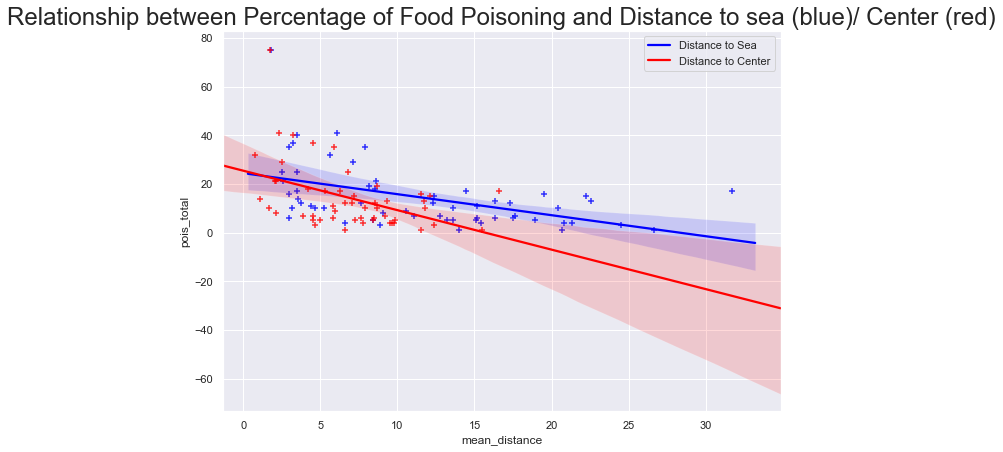

In [69]:
# plotting linear regression
fig = plt.figure(figsize=(10,7))
sns.regplot(x = DF.distance_to_sea, y = DF.pois_total, color = 'blue', marker = '+')
sns.regplot(x = DF.mean_distance, y = DF.pois_total, color = 'red', marker = '+')
plt.title('Relationship between Percentage of Food Poisoning and Distance to sea (blue)/ Center (red)', size = 24)
plt.legend(labels = ['Distance to Sea','Distance to Center'])

We shall compare the correlations by using two methods : pearson and spearman

Spearman: 

In [71]:
# correlation and p-values
len_ = DF_merge.shape[0]
print('The spearman coefficient is : ',stats.spearmanr
      (DF_merge['distance_to_sea'],DF_merge['pois_total']),'n=',len_)
print('The spearman coefficient is : ',stats.spearmanr
      (DF_center['mean_distance'],DF_center['pois_total']),'n=',len_)

The spearman coefficient is :  SpearmanrResult(correlation=-0.5358864192164994, pvalue=1.4567837494007248e-05) n= 58
The spearman coefficient is :  SpearmanrResult(correlation=-0.4394149988616711, pvalue=0.0012550159242211895) n= 58


Pearson:

In [72]:
# Pearson correlation coefficient and p-value for distance to sea
pearson_coef, p_value = stats.pearsonr(DF_merge.distance_to_sea, DF_merge.pois_total)
print(pearson_coef)

# Pearson correlation coefficient and p-value for distance to city center
pearson_coef, p_value = stats.pearsonr(DF_center.mean_distance, DF_center.pois_total)
print(pearson_coef)

-0.48154886851135953
-0.44356603445097864


Spearman is better in this case because our values do not follow a normalized law.

**Observations:** The distance to the sea seems to have a slighty better correlation with the food poisoning. 

# 6- Natural Langage processing of post from iwaspoisonned.com

The complaints written on the website Iwaspoisoned.com are analysed so that we can know what kinds of food cause sicknesses and in which zip codes.

## 6.1 Violations Text Handling

In [75]:
nlp = spacy.load('en')

This function will retrieve all the words that are useful for topic detection. Stopwords are taken out and lemmatization is used.

In [76]:
def get_all_words_from_text (text_):
    TEXT = []
    
    # create document with input text
    doc = nlp(text_)
    token_without_stop_lemma = []
    
    # add all words after "lemmatization conversion"
    for token in doc:
        token_without_stop_lemma.append(token.lemma_)
    
    # the words are now in a list so we join them again into a text
    new_text = ' '.join(word for word in token_without_stop_lemma)
    
    # recreation of a doc
    doc2 = nlp(new_text)
    
    # taking out stopwords and punctuation
    words = [token.text for token in doc2 if token.is_stop != True and token.is_punct != True]
    
    return words

Finding Topics: This function will be handy to pick some topics from the text.

In [77]:
def Topic(df,NUM_TOPICS = 4, num_words_ = 2):

    dictionary = corpora.Dictionary(df.new_list_of_words.values.tolist())
    corpus = [dictionary.doc2bow(text) for text in df.new_list_of_words.values.tolist()]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word = dictionary, passes = 15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words= num_words_)
    for topic in topics:
        print(topic)

Webscraping Text Handling 

Let's import the csv file from the webscraping of the iwaspoisoned website.

In [78]:
# import the cleaning dataset 
data_web = pd.read_csv('data/Food_Poisoning3.csv', delimiter = ',')

# taking only the zip and comments columns
data_web = data_web[['Zip','Comments']]

In comments, we have a text in each row of the report made by a person on food poisoning.

In [79]:
# drop any nan values
data_web.dropna(inplace = True)

# change zip type to int
data_web['Zip'] = data_web['Zip'].astype(int)

# changing the type of zip to int
data_web['Zip'] = list(map(lambda x : int(x) if (math.isnan(x) == False) else np.nan, data_web.Zip.values.tolist()))

# lowercasing everything
data_web['Comments'] = data_web['Comments'].str.lower()


If "inspection failure" is in the comments, then it is not a complaint from a person but a description of an inspection failure. We are only interested in analyzing texts written by people.

In [80]:
# data with "inspection failure" in comments
df_inspection_failures = data_web[data_web['Comments'].str.contains("inspection failure")]

# all rows except the "inspection failures"
df_complaints = data_web[~data_web.isin(df_inspection_failures)].dropna()

This dataframe contains all the comments made by people on the website along 

In [81]:
df_complaints.head()

,Zip,Comments
1,60653.0,“i ordered the ocean perch dinner. a couple ...
3,60616.0,"“chicken wings, ate wings on thursday evenin..."
6,60647.0,"“turkey footlong sub with provolone cheese, ..."
7,60616.0,"“crab rangoon, a few bites tasted fishy. sat..."
8,60656.0,"“eating chinese food, both of us , i initial..."


Some words that aren't stop words do not give insight on the topic but occur many times. We shall discard some of them.

In [82]:
def New_List_Words(data_web):
    list_ = []
    
    # for each row in the dataframe
    for i in range(data_web.shape[0]):
        
        # append the only useful words from the text in a list
        list_.append(get_all_words_from_text(data_web.Comments.values[i]))
    
    # creating a new column with this list
    data_web_words = {'zip': data_web.Zip.values.tolist(), 'list_of_words':list_} 
    
    # Create DataFrame 
    df = pd.DataFrame(data_web_words) 
    
    # useless words in a list
    useless_words= ['inspection','failure','observe','-PRON-','"','issue','instruct','be','premise','have','find','detail','item','area','note','unit','do','start','not','run','get',"  ",'go','continue','take','continue','ask','say',' ','>','   ','\r\n ','30','8']
    
    # list of words from the dataframe
    test_list = df.list_of_words.values.tolist()
    
    # all words in a list of each row
    for w in useless_words:
        
        # if it isn't a useless word, keep it
        res = [[ele for ele in sub if ele != w] for sub in test_list] 
        test_list = res
    
    # creating a new column
    df['new_list_of_words'] = test_list
    
    return df

In [83]:
# applying the function to complaints
df_complaints_ = New_List_Words(df_complaints)

df_complaints_.head()

,zip,list_of_words,new_list_of_words
0,60653.0,"[ , order, ocean, perch, dinner, couple, hou...","[order, ocean, perch, dinner, couple, hour, ea..."
1,60616.0,"[ , chicken, wing, eat, wing, thursday, even...","[chicken, wing, eat, wing, thursday, evening, ..."
2,60647.0,"[ , turkey, footlong, sub, provolone, cheese...","[turkey, footlong, sub, provolone, cheese, spi..."
3,60616.0,"[ , crab, rangoon, bite, taste, fishy, satur...","[crab, rangoon, bite, taste, fishy, saturday, ..."
4,60656.0,"[ , eat, chinese, food, -PRON-, initially, c...","[eat, chinese, food, initially, chest, pain, f..."


Let's try and define some topics:

In [85]:
#select 5 topics of 2 words each
Topic(df_complaints_,5, 2)

(0, '0.040*"eat" + 0.034*"day"')
(1, '0.039*"eat" + 0.030*"hour"')
(2, '0.037*"food" + 0.020*"eat"')
(3, '0.036*"hour" + 0.033*"diarrhea"')
(4, '0.030*"diarrhea" + 0.017*"body"')


In [86]:
#plot topics

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics = False)

pyLDAvis.display(lda_display)

Lexicon :
Lexicon gives us categories of subjects that include lists of related words. We could use this to identify words from a certain topic. For example, we could identify all food related words to identify which types of food have been causing food poisoning. Also, we will investigate on the medical related terms to know more about the symptoms.

In [87]:
lexicon = Empath()

We will now take count the occurences of words in the reports.

In [90]:
list_text = []

# join all words from the lists to create a text

for sentence in df_complaints_.new_list_of_words:
    list_text.append(' '.join(sentence))
text = ' '.join(list_text)

# count frequencies of each word
freq = reduce( lambda d, c: d.update([(c, d.get(c,0)+1)]) or d, text.split(), {})

In [97]:
def make_freq_graph(text):
    
    # get data directory (using getcwd() is needed to support running example in generated IPython notebook)
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

    # read the mask image taken from https://www.canstockphoto.com/chicago-city-map-63451119.html
    chicago_image = np.array(Image.open(path.join(d, "data/istockphoto-908943762-1024x1024.png")))

    # word cloud
    wc = WordCloud(
        background_color="white", 
        max_words=2000, 
        mask= chicago_image,
        contour_width=3, 
        contour_color='steelblue'
    )
    
    # generate word cloud
    wc.generate(text)


    # show
    fig = plt.figure()
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    plt.axis("off")
    plt.show()


<Figure size 432x288 with 0 Axes>

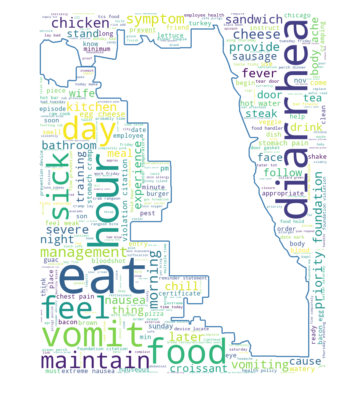

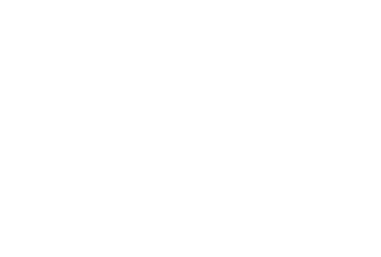

In [98]:
# display image
image_array = make_freq_graph(text)

The bigger the word, the more frequent it is in the reports of food poisoning 

## 6.2  Plotting word frequencies per topic and geography

### 6.2.1 Plotting most frequent words per zip : 

Let's create a dataframe with all words occurences for each zip code.

In [99]:
# count amount of zip codes in groupby
DF_complaints = df_complaints_.groupby('zip').agg(sum)

# reset index
DF_complaints.reset_index(inplace = True)

# delete column
del DF_complaints['list_of_words']

# creation of the dataframce
rows = []
_ = DF_complaints.apply(lambda row: [rows.append([row['zip'], nn]) 
                         for nn in row.new_list_of_words], axis = 1)
df_new = pd.DataFrame(rows, columns = DF_complaints.columns).set_index(['zip'])

In [100]:
df_new.head()

,new_list_of_words
zip,
60601.0,steak
60601.0,burrito
60601.0,black
60601.0,bean
60601.0,brown


In [101]:
# reset index
df_new.reset_index(inplace = True)

# counting occurences
df_new = df_new.groupby(df_new.columns.tolist()).size().\
    rename(columns={0:'records'})

# reset index
df_new = df_new.reset_index()

# defining columns
df_new.columns = ['zip', 'words','counts']

# joining all words in the list from column 'new_list_of_words'
Text = []
for i in range(df_complaints_.shape[0]):
    Text.append( ' '.join(df_complaints_.new_list_of_words.values[i]))

# create new column
df_complaints_['text'] = Text

df_complaints_.head()

,zip,list_of_words,new_list_of_words,text
0,60653.0,"[ , order, ocean, perch, dinner, couple, hou...","[order, ocean, perch, dinner, couple, hour, ea...",order ocean perch dinner couple hour eat stoma...
1,60616.0,"[ , chicken, wing, eat, wing, thursday, even...","[chicken, wing, eat, wing, thursday, evening, ...",chicken wing eat wing thursday evening feel si...
2,60647.0,"[ , turkey, footlong, sub, provolone, cheese...","[turkey, footlong, sub, provolone, cheese, spi...",turkey footlong sub provolone cheese spinach v...
3,60616.0,"[ , crab, rangoon, bite, taste, fishy, satur...","[crab, rangoon, bite, taste, fishy, saturday, ...",crab rangoon bite taste fishy saturday nov fev...
4,60656.0,"[ , eat, chinese, food, -PRON-, initially, c...","[eat, chinese, food, initially, chest, pain, f...",eat chinese food initially chest pain feel lik...


In [102]:
# join all texts
Text = ' '.join(df_complaints_.text.values)
split_it = Text.split() 

# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 

# most_common() produces k frequently encountered 
most_occur = Counter.most_common(50) 

In [103]:
# only take the word and not it's frequency
most_occur_words = [x[0] for x in most_occur] 

50 most frequent terms with respect to the zip code


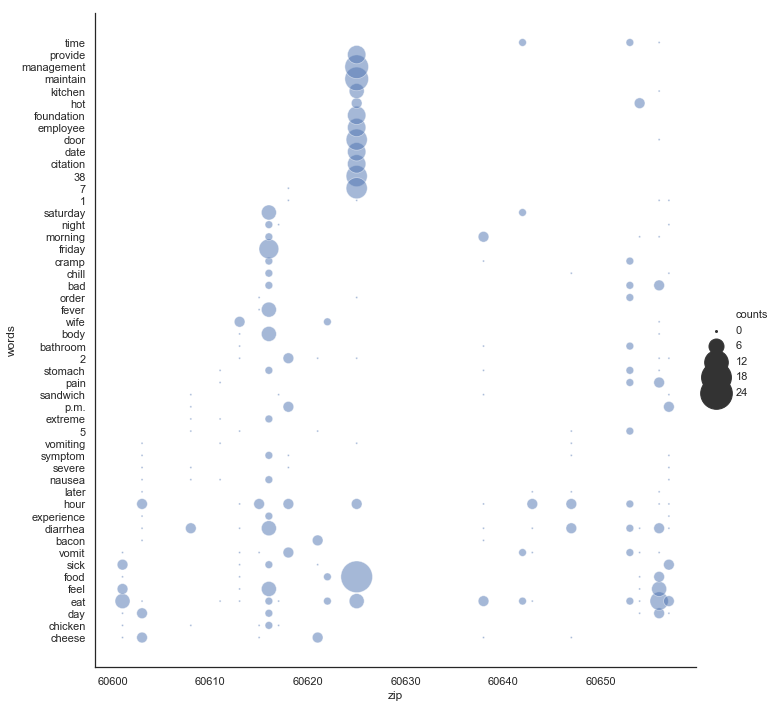

In [112]:
# dataframe with only the 50 most occuring words
df_new2 = df_new.loc[df_new.words.isin(most_occur_words) ]

sns.set(style = "white")

# Plot
sns.relplot(
    x = "zip", 
    y = "words", 
    size = "counts",
    sizes = (4, 1000), 
    alpha = .5, 
    palette = "muted",
    height = 10, 
    data = df_new2
)
print( '50 most frequent terms with respect to the zip code')

This plot gives us the 50 most frequent words and their occurences per zip code. 

### 6.2.2  Words in a certain category per distance to the sea 

The proximity to the sea has been proven to be correlated with the food poisoning due to Ecoli infections. We will see which terms appear with respect to the distance to the sea of the concerned facility.

> The categories of interest are :
    - Medical Emergencies
    - Types of Food

In [105]:
# new list
Medical_Emergency = []
for w in df_new.words:
    
    # if a word is in the categories related to health
    if (w in lexicon.cats['medical_emergency'])or(w in lexicon.cats['health'])or(w in lexicon.cats['suffering'])or(w in lexicon.cats['pain']):
        
        # add to list
        Medical_Emergency.append(w)

        # drop duplicates
Medical_Emergency = list(dict.fromkeys(Medical_Emergency))

Food = []
for w in df_new.words:
    
    # if the word is in a category related to food
    if (w in lexicon.cats['cooking']) or (w in lexicon.cats['eating']):
        
        # add to list
        Food.append(w)
        
# drop duplicates
Food = list(dict.fromkeys(Food))

In [108]:
# import distance to sea csv file
dist_sea_zip = pd.read_csv('data/Distance_sea_zip.csv')

In [109]:
def relplot_df(df):
    
    fig = plt.figure()
    
    sns.set(style="white")
    
    # plotting
    sns_plot = sns.relplot(x="distance_to_sea", y="words", size="counts",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)


Medical Emergency plot:

 Most frequent health related terms with respect to the distance to the sea


<Figure size 432x288 with 0 Axes>

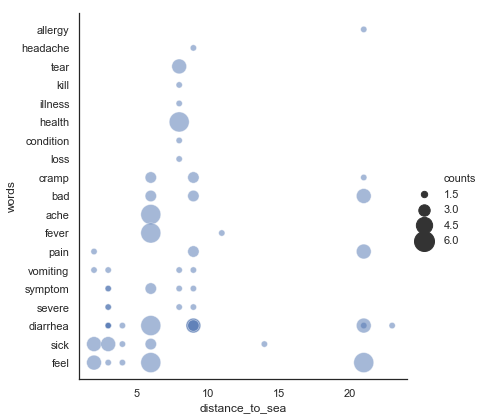

In [110]:
# find words that are in the list of medical emergency terms
df_emergency = df_new.loc[df_new.words.isin(Medical_Emergency) ]

# merge with distance to sea
df_emergency = pd.merge(df_emergency, dist_sea_zip, on='zip', how='outer')

# drop nan
df_emergency = df_emergency.dropna()

# round the distance to sea
df_emergency['distance_to_sea']= round(df_emergency['distance_to_sea'])

# plot
relplot_df(df_emergency)
print(' Most frequent health related terms with respect to the distance to the sea')

Types of food plot : 

 Most frequent food related terms with respect to the distance to the sea


<Figure size 432x288 with 0 Axes>

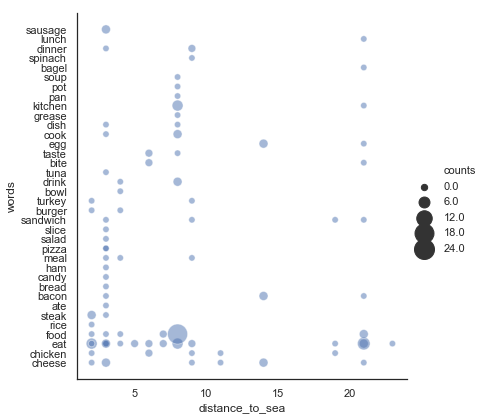

In [111]:
# find words that are in the list of food terms
df_food = df_new.loc[df_new.words.isin(Food) ]

# merge with distance to sea
df_food = pd.merge(df_food, dist_sea_zip, on='zip', how='outer')

# drop nan
df_food =df_food.dropna()

# round the distance to sea
df_food['distance_to_sea']= round(df_food['distance_to_sea'])

# plot
relplot_df(df_food)
print(' Most frequent food related terms with respect to the distance to the sea')

These two graphs show that overall, there are more occurences that happen near the sea which implies that food poisoning is most important near the sea (perhaps because of Ecoli). Meat related terms in particular are more frequent near the sea, which confirms our hypothesis on Ecoli infections because they are mainly caused by uncooked meat.

# 7- Applied marching learning 

In this section, we will train and test a machine learning model that can predict food poisoning cases. This will alert Chicago health care department about these restaurants that might promote the spread of food-borne illness with high risk of poisoning for the population. The features will mainly include: The list of violations committed during an inspection, the location (zip code),  and the risk factor of the restaurant.

> Since the variable that we want to predict is categorical (discrete), we will use a classification method. The classifiers that we select are Random forest and Gradient Boosted Trees.

In [2]:
# labels
class_names = ['No Food Poisoning', 'Food Poisoning']
np.set_printoptions(precision = 2)

## 7.1 Data extraction

In [5]:
# read from saved csv
violations_dataframe01 = pd.read_csv('data/violations_binary_representation.csv')
violations_dataframe02 = pd.read_csv('data/violations_type_count.csv')

print(print('\n\033[1m Violations per inspection (binary value representation) \033[0m'))
display(violations_dataframe01.head(3))

print(print('\n\033[1m Number of critical ,serious and minor count per inspection \033[0m'))
display(violations_dataframe02.head(3))


 Violations per inspection (binary value representation) 
None


,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346127,2637127.0,Canvass Re-Inspection,60630.0,Risk 1 (High),Pass
1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346126,2432147.0,Canvass Re-Inspection,60632.0,Risk 2 (Medium),Pass w/ Conditions
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346149,2215652.0,Canvass,60652.0,Risk 1 (High),Fail



 Number of critical ,serious and minor count per inspection 
None


,Unnamed: 0,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,critical_count,serious_count,minor_count,violations_count
0,0,2346127,CREPE HOUSE CAFE,CREPE HOUSE CAFE,2637127.0,Restaurant,Risk 1 (High),5033 N ELSTON AVE,60630.0,2019-11-22,Canvass Re-Inspection,Pass,0,41.972349,-87.746825,"{'latitude': '-87.74682508578468', 'longitude'...",0.000000,0.0,0.000000,0.0
1,1,2346126,LEANS NUTRITION CLUB,LEANS NUTRITION CLUB,2432147.0,Restaurant,Risk 2 (Medium),5302 S PULASKI RD,60632.0,2019-11-22,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.796699,-87.723408,"{'latitude': '-87.72340756196249', 'longitude'...",1.000000,0.0,0.000000,2.0
2,2,2346149,PINKS CHILD CARE ACADEMY II,PINK'S CHILD CARE ACADEMY II,2215652.0,Daycare Combo 1586,Risk 1 (High),8000 S KEDZIE AVE,60652.0,2019-11-22,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.747934,-87.702489,"{'latitude': '-87.70248876124471', 'longitude'...",0.666667,0.0,0.333333,3.0


- **df_New**: In order to be able to train the model effectively, we need to take into consideration the time property of our initial dataset: indeed, each restaurant will face many inspections throughout the years, and the inspections are thus ordered in time. Hence, our model needs to take into account the time property of the dataset. This will be enabled by first ordering the inspections in the dataset (from first to last inspections).

> We will add the inspection date to each of the inspections, recorded with their separate violations, by merging both 'violations_dataframe' (for the separate violations) and 'violations_dataframe02' (for the inspection dates). Since both dataframes contains the inspection_id, which is unique for each inspection, we can merge by 'inspection_id'.

In [6]:
# Extract the date of inspection
df2 = violations_dataframe02[["inspection_id",'inspection_date']]
df2.head(2)

,inspection_id,inspection_date
0,2346127,2019-11-22
1,2346126,2019-11-22


In [7]:
# Merge on inspection_id
df_New = pd.merge(df2, violations_dataframe01, left_index=True, right_index=True, how='outer', on='inspection_id')
df_New.head(2)

,inspection_id,inspection_date,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
0,2346127,2019-11-22,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2637127.0,Canvass Re-Inspection,60630.0,Risk 1 (High),Pass
1,2346126,2019-11-22,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2432147.0,Canvass Re-Inspection,60632.0,Risk 2 (Medium),Pass w/ Conditions


In [8]:
# Convert into date format
df_New["inspection_date"] = pd.to_datetime(df_New["inspection_date"])

# Sort the inspections by date
df_New = df_New.sort_values(by ="inspection_date",ascending=True)
df_New.head()

,inspection_id,inspection_date,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
134276,104236,2010-01-04,134276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,80916.0,Canvass,60611.0,Risk 1 (High),Fail
134251,158242,2010-01-05,134251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,66827.0,Canvass,60609.0,Risk 2 (Medium),Pass w/ Conditions
134250,124257,2010-01-05,134250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17145.0,Canvass,60630.0,Risk 1 (High),Pass
134249,124256,2010-01-05,134249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1915768.0,Canvass,60631.0,Risk 1 (High),Pass
134248,134238,2010-01-05,134248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1964634.0,Canvass,60647.0,Risk 1 (High),Pass


- **data_classified**: Another ordered time series dataset that we can think about and is relevant to use is obtained by grouping the inspections (sorted by time, from the oldest to the most recent ones) by restaurant license (i.e. sorted inspections for each restaurant).

> We group the inspections sorted by time (from the oldest to the newest) by restaurant license.

In [9]:
# create a dataframe with data grouped by license number

dict_resto_1 = {}

for resto, df in df_New.groupby('license'):
  dict_resto_1[resto] = df

data_classified = pd.concat(dict_resto_1.values(), sort = True, ignore_index=True)
data_classified.head()

,#1,#10,#11,#12,#13,#14,#15,#16,#17,#18,...,#8,#9,Unnamed: 0,inspection_date,inspection_id,inspection_type,license,results,risk,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,128883,2010-06-15,229468,Canvass,2.0,Pass,Risk 1 (High),60606.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,121035,2011-02-15,114767,Canvass,2.0,Pass,Risk 1 (High),60606.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,107301,2012-03-19,679663,Canvass,2.0,Pass w/ Conditions,Risk 1 (High),60606.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,107190,2012-03-21,680088,Canvass Re-Inspection,2.0,Pass,Risk 1 (High),60606.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,90188,2013-07-19,1324560,Canvass,2.0,Pass,Risk 1 (High),60606.0


- **df_New_2**: We load the dataset in which we computed a personalized score for each of the inspections. We merge it with the other ones in order to have the list of violations and the inspection date.

In [11]:
# Load the dataset
data_score = pd.read_csv('data/score_violation_df.csv', delimiter = ',')
data_score.head()

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,#37,#38,#39,#40,#41,#42,#43,#44,#70,score
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740464
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.832479
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
# Extracting the score parameter
df_score = data_score[["score"]]
df_score.head(2)

,score
0,0.000000
1,1.740464


In [13]:
# Violations and score
df_New_2 = pd.merge(df_score, violations_dataframe01, left_index = True, right_index = True, how = 'outer')
df_New_2.head(2)

,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
0,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346127,2637127.0,Canvass Re-Inspection,60630.0,Risk 1 (High),Pass
1,1.740464,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346126,2432147.0,Canvass Re-Inspection,60632.0,Risk 2 (Medium),Pass w/ Conditions


In [14]:
# Violations, scores and inspection_date
df_New_2 = pd.merge(df2, df_New_2, left_index = True, right_index = True, how = 'outer', on = 'inspection_id')
df_New_2.head(3)

,inspection_id,inspection_date,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
0,2346127,2019-11-22,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2637127.0,Canvass Re-Inspection,60630.0,Risk 1 (High),Pass
1,2346126,2019-11-22,1.740464,1,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2432147.0,Canvass Re-Inspection,60632.0,Risk 2 (Medium),Pass w/ Conditions
2,2346149,2019-11-22,2.832479,2,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2215652.0,Canvass,60652.0,Risk 1 (High),Fail


In [15]:
# Convert into date format
df_New_2["inspection_date"] = pd.to_datetime(df_New_2["inspection_date"])

# Sort the inspections by date
df_New_2 = df_New_2.sort_values(by = "inspection_date", ascending = True)
df_New_2.head()

,inspection_id,inspection_date,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,...,#41,#42,#43,#44,#70,license,inspection_type,zip,risk,results
134276,104236,2010-01-04,4.433844,134276,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,80916.0,Canvass,60611.0,Risk 1 (High),Fail
134251,158242,2010-01-05,1.658378,134251,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,66827.0,Canvass,60609.0,Risk 2 (Medium),Pass w/ Conditions
134250,124257,2010-01-05,0.000000,134250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17145.0,Canvass,60630.0,Risk 1 (High),Pass
134249,124256,2010-01-05,1.037008,134249,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1915768.0,Canvass,60631.0,Risk 1 (High),Pass
134248,134238,2010-01-05,1.037008,134248,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1964634.0,Canvass,60647.0,Risk 1 (High),Pass


## 7.2 Encoding the data

Here, we encode our categorical data into numerical values. For the ordinal features (risk factor, result of inspection) we proceeded with an ordinal encoding. We used hot-encoding for the other categorical data (zip code). 

**Encoding of target variable**: Here we create a model to predict the inspections related to food poisoning, i.e. we're only interested in the type of inspection named: 'Suspected Food Poisoning'. We also mapped each value of the inspection type column into a binary value (binary-class): 1 for the food poisoning related, and 0 for all other inspections.

In [16]:
# Encoding the features and the target

# Associate a number to each value of the risk factor
risk_mapper = {'Risk 1 (High)':3,'Risk 2 (Medium)':2,'Risk 3 (Low)':1}

# Associate a number to each value of the results
result_mapper = {'Pass':1,'Pass w/ Conditions':0,'Fail':-1}

# Replace them in the dataframes

# data_classified
data_classified['risk'] = data_classified['risk'].replace(risk_mapper).astype(int)
data_classified['results'] = data_classified['results'].replace(result_mapper).astype(int)
data_classified = pd.get_dummies(data_classified, columns = ['zip', 'inspection_type'])

# df_New
df_New['risk'] = df_New['risk'].replace(risk_mapper).astype(int)
df_New['results'] = df_New['results'].replace(result_mapper).astype(int)
df_New = pd.get_dummies(df_New, columns = ['zip', 'inspection_type'])

# df_New_2
df_New_2['risk'] = df_New_2['risk'].replace(risk_mapper).astype(int)
df_New_2['results'] = df_New_2['results'].replace(result_mapper).astype(int)
df_New_2 = pd.get_dummies(df_New_2, columns = ['zip', 'inspection_type'])

# Display one of the datasets
df_New.head()

,inspection_id,inspection_date,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,...,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Canvass,inspection_type_Canvass Re-Inspection,inspection_type_Complaint,inspection_type_Complaint Re-Inspection,inspection_type_Short Form Complaint,inspection_type_Suspected Food Poisoning,inspection_type_Suspected Food Poisoning Re-inspection
134276,104236,2010-01-04,134276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134251,158242,2010-01-05,134251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134250,124257,2010-01-05,134250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134249,124256,2010-01-05,134249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134248,134238,2010-01-05,134248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


## 7.3 Training a model that maximizes the accuracy

Here, we will train two models: a random forest classifier and an XGBoost. Cross-validation will be performed to compute the best parameter for each classifier, before fitting the model and testing its accuracy on the test set. For this purpose, we will split our data using the 'TimeSeriesSplit' provided by Sklearn, which provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets, with a condition that the test indices must be higher than before in each splits.

> First, we use our sorted dataset **df_New**. 

In [17]:
# Drop unnecessary columns from the dataset sorted by time of inspection
df_01 = df_New.drop(['inspection_id', 'license', 'inspection_date',
                    'inspection_type_Canvass',
                    'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
                    'inspection_type_Complaint Re-Inspection',
                    'inspection_type_Short Form Complaint',
                    'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)
df_01.head(2)

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Suspected Food Poisoning
134276,134276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134251,134251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Make the features and target dataframes and display the features dataframe
target_df_01 = df_01['inspection_type_Suspected Food Poisoning']
features_df_01 = df_01.drop(['inspection_type_Suspected Food Poisoning'], axis = 1)
features_df_01.head(2)

,Unnamed: 0,#1,#2,#3,#4,#5,#6,#7,#8,#9,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
134276,134276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134251,134251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Train and test sets for time series dataframes
X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(features_df_01, target_df_01, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

In [24]:
# XGB classifier
y_pred_1_XGB, XGB_classifier_1 = GBT_classification(X_train_df1, y_train_df1, X_test_df1, y_test_df1, tscv, score = 'accuracy')

Gradient Boosted trees model accuracy score : 0.9949359547214776
Gradient Boosted trees model F1 score : 0.9924103594952173


In [27]:
# Random Forest classifier
y_pred_1_rf, rf_classifier_1 = Rf_classification(X_train_df1, y_train_df1, X_test_df1, y_test_df1, tscv, score = 'accuracy')

rf classifer accuracy = 0.9948


**Observations**: The accuracy seems unusually high. Thus, we decided to compute a correlation matrix in order to have a more quantitative overview. 

[[26720     0]
 [  136     0]]


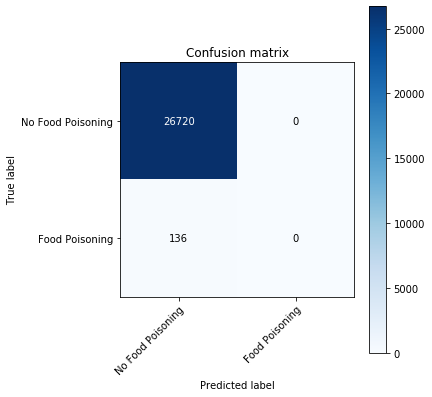

In [56]:
# Confusion matrix for XGB
plot_confusion_matrix(y_test_df1, y_pred_1_XGB, classes=class_names,title='Confusion matrix', figsize=(6,6))
plt.savefig('CM_1.png')

[[26717     3]
 [  136     0]]


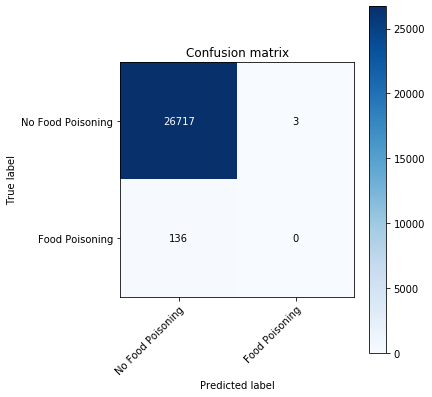

In [55]:
# Confusion matrix for Random Forest
plot_confusion_matrix(y_test_df1, y_pred_1_rf, classes=class_names,title='Confusion matrix', figsize=(6,6))

> Although both models yield a very high accuracy, they are completely unefficient at predicting food poisoning cases. This suggests that the data we have is unbalanced. We decided to plot the class distribution to confirm this hypothesis.

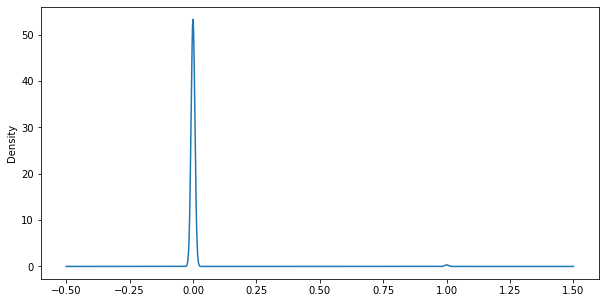

In [29]:
# Plot the density for each class
plt.figure(figsize=(10,5))
df_New['inspection_type_Suspected Food Poisoning'].plot(kind='density', subplots=True, sharex=False)
plt.show()

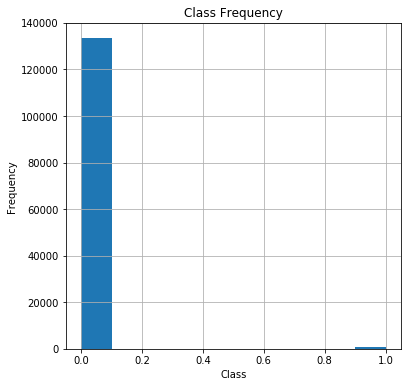

In [31]:
# Plot the class distribution as histograms
plt.figure(figsize=(6,6))
df_New['inspection_type_Suspected Food Poisoning'].hist()
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

> **Conclusions**: Indeed, the class is extremely unbalanced. Hence, accuracy is not a reliable metric for the real performance of tested classifiers here, and yields misleading results if the data set is unbalanced (that is, the numbers of observations in different classes vary greatly, which is pretty obvious by looking at the histogram).

## 7.4 Training a model suited for unbalanced data

The F1 score often turns to be a better metric when dealing with unbalanced data. Moreover, XGBoost is better equipped for this kind of use. Hence, we will train an XGBoost model that tend to maximise the F1_score rather than the accuracy. 

**1)** First, using the sorted dataset grouped by licence, **data_classified**.

In [32]:
# Drop unnecessary columns from the dataset sorted by time of inspection
df_02 = data_classified.drop(['inspection_id', 'license', 'inspection_date',
                    'inspection_type_Canvass',
                    'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
                    'inspection_type_Complaint Re-Inspection',
                    'inspection_type_Short Form Complaint',
                    'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)
df_02.head(2)

,#1,#10,#11,#12,#13,#14,#15,#16,#17,#18,...,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Suspected Food Poisoning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Make the features and target dataframes and display the features dataframe
target_df_02 = df_02['inspection_type_Suspected Food Poisoning']
features_df_02 = df_02.drop(['inspection_type_Suspected Food Poisoning'], axis = 1)
features_df_02.head(2)

,#1,#10,#11,#12,#13,#14,#15,#16,#17,#18,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Train and test sets for time series dataframes
X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(features_df_02, target_df_02, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

> Additionally, we passed the ratio of the dominant binary class (0) over the minimal class (1) to the 'scale_pos_weight' argument of the XGBClassifier. This enables to put a weight on the dominant class, and obtain better results for unbalanced data.

In [35]:
# Compute the ratio

y_train_OK = y_train_df2[y_train_df2 == 1]
len_OK = len(y_train_OK)

y_train_not_OK = y_train_df2[y_train_df2  == 0]
len_not_OK = len(y_train_not_OK)

ratio_train = float(len_not_OK/len_OK)

In [36]:
# Cross validation to optimize F1 score, test set validation
y_pred_2, XGB_classifier_2 = GBT_classification(X_train_df2, y_train_df2, X_test_df2, y_test_df2, tscv, ratio_train)

Gradient Boosted trees model accuracy score : 0.851131963062258
Gradient Boosted trees model F1 score : 0.9156952638609427


[[22816  3928]
 [   70    42]]


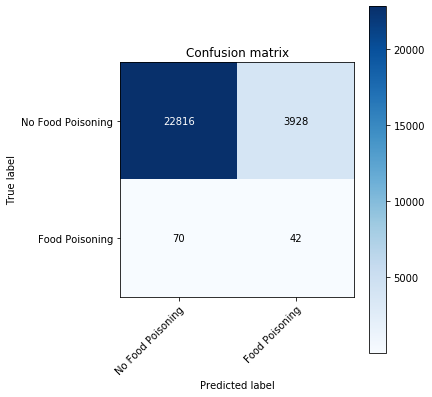

In [42]:
# Confusion matrix 
plot_confusion_matrix(y_test_df2, y_pred_2, classes=class_names,title='Confusion matrix', figsize=(6,6))

> **Observation**: Increase in the number of Food poisoning correctly identified as such (True positives). Also, the False Negatives value is greater (True 'Food Poisoning' classified as 'No Food Poisoning'), and this model will most likely fail at classifying correctly cases of food poisoning.

**2)** We decided to try to train our model with the other sorted dataset **df_New**.

In [80]:
# Drop unnecessary columns from the dataset sorted by time of inspection
df_03 = df_New.drop(['inspection_id', 'license', 'inspection_date', 'Unnamed: 0',
                    'inspection_type_Canvass',
                    'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
                    'inspection_type_Complaint Re-Inspection',
                    'inspection_type_Short Form Complaint',
                    'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)
df_03.head(2)

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Suspected Food Poisoning
134276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# Make the features and target dataframes and display the features dataframe
target_df_03 = df_03['inspection_type_Suspected Food Poisoning']
features_df_03 = df_03.drop(['inspection_type_Suspected Food Poisoning'], axis = 1)
features_df_03.head(2)

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
134276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# Train and test sets for time series dataframes 
X_train_df3, X_test_df3, y_train_df3, y_test_df3 = train_test_split(features_df_03, target_df_03, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

# Compute the ratio

y_train_OK = y_train_df3[y_train_df3 == 1]
len_OK = len(y_train_OK)

y_train_not_OK = y_train_df3[y_train_df3 == 0]
len_not_OK = len(y_train_not_OK)

ratio_train = float(len_not_OK/len_OK)

In [83]:
# Cross validation to optimize F1 score, test set validation
y_pred_3, XGB_classifier_3 = GBT_classification(X_train_df3, y_train_df3, X_test_df3, y_test_df3, tscv, ratio_train)

Gradient Boosted trees model accuracy score : 0.5861260053619303
Gradient Boosted trees model F1 score : 0.7344620851402038


[[15665 11055]
 [   60    76]]


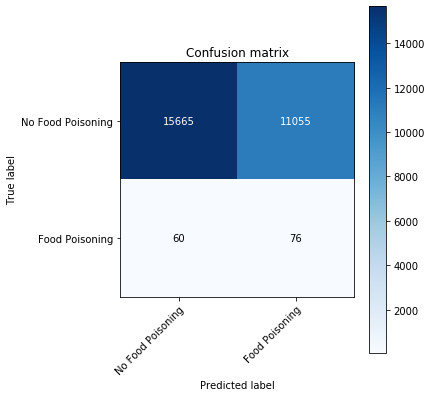

In [84]:
# Confusion matrix 
plot_confusion_matrix(y_test_df3, y_pred_3, classes=class_names,title='Confusion matrix', figsize=(6,6))

> **Observation**: An even higher increase in the number of Food poisoning correctly identified as such (True positives) is observed. Moreover, the False Negatives value is also lower compared with the previous model (True 'Food Poisoning' classified as 'No Food Poisoning'), and this model is more suited for classifying correctly cases of food poisoning, even though we loose some accuracy.

**3)** Dataset with the score value (**df_New_2**).

In [48]:
df_New_2.head(2)

,inspection_id,inspection_date,score,Unnamed: 0,#1,#2,#3,#4,#5,#6,...,zip_60666.0,zip_60707.0,zip_60827.0,inspection_type_Canvass,inspection_type_Canvass Re-Inspection,inspection_type_Complaint,inspection_type_Complaint Re-Inspection,inspection_type_Short Form Complaint,inspection_type_Suspected Food Poisoning,inspection_type_Suspected Food Poisoning Re-inspection
134276,104236,2010-01-04,4.433844,134276,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
134251,158242,2010-01-05,1.658378,134251,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [49]:
# Drop useless columns from the dataset of interest
df_04 = df_New_2.drop(['inspection_type_Canvass',
       'inspection_type_Canvass Re-Inspection', 'inspection_type_Complaint',
       'inspection_type_Complaint Re-Inspection',
       'inspection_type_Short Form Complaint',
       'inspection_type_Suspected Food Poisoning Re-inspection'], axis = 1)

del df_04['Unnamed: 0']


# Make the features and target dataframes and display the features dataframe
target_df_04 = df_04['inspection_type_Suspected Food Poisoning']
features_df_04 = df_04.drop(['inspection_type_Suspected Food Poisoning', 'inspection_date', 'inspection_id', 'license'], axis = 1)

# Drop the violations
features_df_04 = features_df_04[features_df_04.columns.drop(list(features_df_04.filter(regex='#')))]
features_df_04.head(2)

,score,risk,results,zip_60601.0,zip_60602.0,zip_60603.0,zip_60604.0,zip_60605.0,zip_60606.0,zip_60607.0,...,zip_60654.0,zip_60655.0,zip_60656.0,zip_60657.0,zip_60659.0,zip_60660.0,zip_60661.0,zip_60666.0,zip_60707.0,zip_60827.0
134276,4.433844,3,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134251,1.658378,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Train and test sets for time series dataframes 
X_train_df4, X_test_df4, y_train_df4, y_test_df4 = train_test_split(features_df_04, target_df_04, test_size = 0.2, shuffle = False)
tscv = TimeSeriesSplit(n_splits = 5)

# Compute the ratio

y_train_OK = y_train_df4[y_train_df4 == 1]
len_OK = len(y_train_OK)

y_train_not_OK = y_train_df4[y_train_df4  == 0]
len_not_OK = len(y_train_not_OK)

ratio_train = float(len_not_OK/len_OK)

In [51]:
# Cross validation to optimize F1 score, test set validation
y_pred_4, XGB_classifier_4 = GBT_classification(X_train_df4, y_train_df4, X_test_df4, y_test_df4, tscv, ratio_train)

Gradient Boosted trees model accuracy score : 0.5406985403634197
Gradient Boosted trees model F1 score : 0.6970553634132073


[[14427 12293]
 [   42    94]]


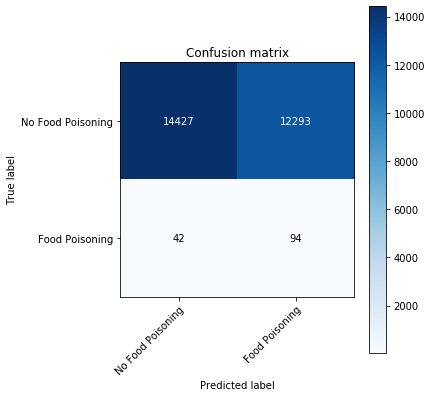

In [54]:
# Plot confusion matrix
plot_confusion_matrix(y_test_df4, y_pred_4, classes=class_names,title='Confusion matrix', figsize=(6,6))
plt.savefig('CM_2.png')

> **Observation**: This model is the best in terms of correct classification food poisoning cases.

### 7.4.1 ROC-curve analysis

A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers. It is obtained by plotting the true positive rate (TPR) against the false positive rate (FPR). Both axes vary between 0 and 1, and the closer the curve is to the upper-left corner, the better is the performance of the model. Moreover, the shape of the ROC curve does not depend on the class distribution, which makes it even better suited for use in our case.

> We plot ROC curves on the same figure for all models, and display the roc-auc score.

roc_auc_score model 1:  0.6140629673945558
roc_auc_score model 2:  0.5408671627333568
roc_auc_score model 3:  0.6155545526593871


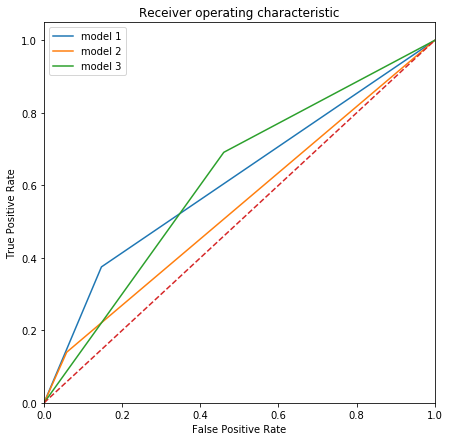

In [65]:
fpr_2, fpr_3, fpr_4 = dict(), dict(), dict()
tpr_2, tpr_3, tpr_4 = dict(), dict(), dict()
roc_auc_2, roc_auc_3, roc_auc_4 = dict(), dict(), dict()
for i in range(2):
    fpr_2[i], tpr_2[i], _ = roc_curve(y_test_df2, y_pred_2)
    roc_auc_2[i] = auc(fpr_2[i], tpr_2[i])
    fpr_3[i], tpr_3[i], _ = roc_curve(y_test_df3, y_pred_3)
    roc_auc_3[i] = auc(fpr_3[i], tpr_3[i])
    fpr_4[i], tpr_4[i], _ = roc_curve(y_test_df4, y_pred_4)
    roc_auc_4[i] = auc(fpr_4[i], tpr_4[i])
  


print('roc_auc_score model 1: ',roc_auc_score(y_test_df2, y_pred_2))
print('roc_auc_score model 2: ',roc_auc_score(y_test_df3, y_pred_3))
print('roc_auc_score model 3: ',roc_auc_score(y_test_df4, y_pred_4))
plt.figure(figsize=(7,7))
plt.plot(fpr_2[1], tpr_2[1], label='model 1')
plt.plot(fpr_3[1], tpr_3[1], label = 'model 2')
plt.plot(fpr_4[1], tpr_4[1], label = 'model 3')
plt.plot ([0.0, 1.0], [0.0, 1.0], '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.savefig('ROC.png')
plt.show()

**Conclusions**: The third model built using the **df_New_2** dataset (the one containing the score computed based on the violations) offers the best performance in terms of ROC-AUC score, F1 score and sensitivity. However, it could be improved by having more data related to food poisoning inspections, which will help to balance the dataset, for instance, or more correlated features. Another limitation of this model is that the score was computed by us, and could introduce some bias.
Based on the AUC score, the best model seems to be the model 3 .

### 7.4.2 Most correlated features for predicting cases of food poisoning inspections

Here, we tried to look at the features that were of greatest importance in building the models.

In [72]:
# Display important features for model 3
feature_importances_1 = pd.DataFrame(XGB_classifier_4.feature_importances_,
                                   index = X_train_df4.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances_1.head()

,importance
score,0.275742
zip_60611.0,0.113371
risk,0.111624
zip_60623.0,0.083874
zip_60617.0,0.082845


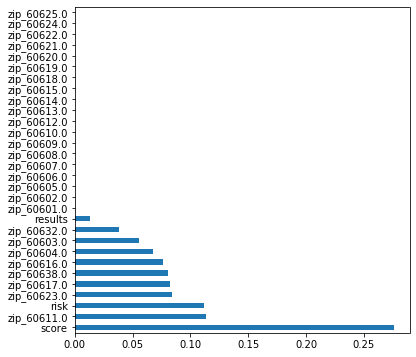

In [74]:
# Show them in a histogram
feat_importances = pd.Series(XGB_classifier_4.feature_importances_, index=X_train_df4.columns)
feat_importances.nlargest(30).plot(kind='barh', figsize=(6,6))

> **Observation 1**: The model gets most of its predictive power from the score. Violations seem to be more correlated with the food poisoning than the locations.

In [85]:
# Display important features for model 3
feature_importances_2 = pd.DataFrame(XGB_classifier_3.feature_importances_,
                                   index = X_train_df3.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances_2.head()

,importance
#3,0.139457
#33,0.045129
risk,0.043177
zip_60611.0,0.042980
#6,0.041738


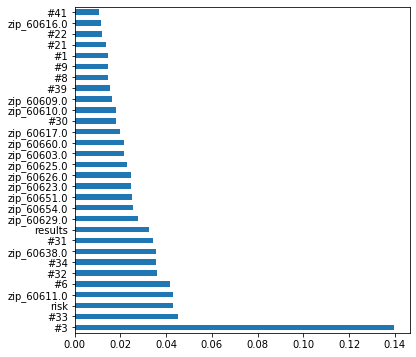

In [86]:
# Show them in a histogram
feat_importances = pd.Series(XGB_classifier_3.feature_importances_, index=X_train_df3.columns)
feat_importances.nlargest(30).plot(kind='barh', figsize=(6,6))

**Observation 2**:  The model gets most of its predictive power from the third violation (related to the temperature of food storage) and from other minor violations. Some locations are also more represented than others.

# GENERAL CONCLUSION 

We can't predict food poisoning but we can prevent it . cf [data story](https://marisofie.github.io/epfl_ada_project/)